In [283]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
%matplotlib inline
import seaborn as sns
from scipy.integrate import ode

## Plot NY

In [243]:
ny_df = pd.read_csv('../data/ny_state.csv', parse_dates = True)

In [247]:
ny_df.fillna(0, inplace=True)

In [269]:
dates = ny_df['DATE_OF_INTEREST']
deaths = ny_df['Deaths']
ny_df['ma_deaths'] = ma(deaths.as_matrix(), n=3)

In [262]:
def ma(a, n=3):
    l = len(a)
    a = np.concatenate((np.zeros(n-1), a, [a[-1]]*n))
    maa = [np.sum(a[n-1+i-int(np.floor(n/2)):n-1+i+int(np.ceil(n/2))]) for i in range(l)]
    return np.asarray(maa) / n

In [316]:
gamma = 1/14
ma_deaths = ny_df['ma_deaths']
cumulative_deaths = [ma_deaths[0]]
for i,c in enumerate(ma_deaths[1:]):
    cumulative_deaths.append(cumulative_deaths[i]*(1-gamma) + c)

ny_df['Cumulative_Deaths'] = cumulative_deaths

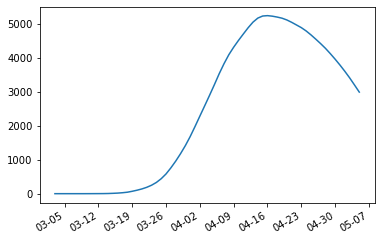

In [317]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))

plt.plot(list(map(datetime.strptime, dates, len(dates)*['%m/%d/%y'])), cumulative_deaths)

plt.gcf().autofmt_xdate()
plt.show()

## Fit model

In [87]:
from scipy.optimize import curve_fit

In [333]:
# Population parameters
N = 8.39e6
I0 = 1
R0 = 0
S0 = N - I0 - R0

## Disease parameters
r0 = 5#2.28
# recovery rate
gamma = 1/14

# contact transmission probability
beta = r0*gamma

## Simulation parameters
time_range = np.arange(1,400)

## Distancing effect: fraction of baseline interactions
pi = np.ones(len(time_range))

print(f'beta={beta}, gamma={gamma}')

beta=0.3571428571428571, gamma=0.07142857142857142


In [334]:
## SIR Model (stationary, t for odeint compliance)
def deriv(y, t, N, beta, gamma, pi):
    S, I, R = y
    #gamma = 1/max(np.random.normal(14,4), 7)
    #beta = max(1,np.random.normal(2.28, 1)) * gamma
    dSdt = -beta * S * I / N * pi[int(t)]
    dIdtp = beta * S * I / N * pi[int(t)]
    dIdtn = -gamma * I
    dRdt = gamma * I
    return [0, dSdt], [dIdtp, dIdtn], [dRdt , 0]

def time_step(deriv, y0, ts, args, cumulative=True):
    states = [np.asarray(y0)]
    new = [np.zeros((len(y0),2))]
    for dt,t in zip(ts[1:] - ts[:-1], ts[1:]):
        curr = states[-1]
        derivatives = np.asarray(deriv(curr, t, *args))
        states.append(curr + derivatives.sum(axis=1)*dt)
        new.append(derivatives*dt)

    if cumulative:
        return np.asarray(states)
    else:
        return np.asarray(new)

In [335]:
def exp(low, dt, t0, ts):
    """
    low : the asymptotic reduced contact level
    dt : number of days to half the contact
    t0 : when measure are implemented
    ts : the time range
    """
    c = -np.log((2 - low/100) / (1 - low/100)) / dt
    pi = np.ones(len(ts) + 1)
    pi[t0:-1] = (1 - low/100) * np.exp(c*(ts[t0:]-ts[t0])) + low/100

    return(pi)

In [336]:
pi_dict = {
    "Baseline": np.ones(len(time_range)+1),
    "Exp Drop to 50%, 5 days": exp(50, 3, 7, time_range),
    "Exp Drop to 50%, 10 days": exp(50, 3, 14, time_range),
    "Exp Drop to 50%, 15 days": exp(50, 3, 21, time_range),
}

y0 = (S0, I0, R0)

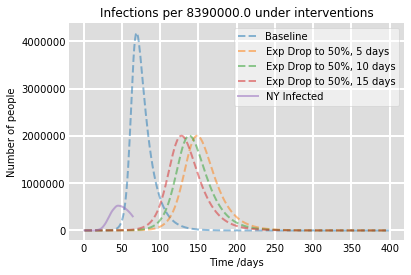

In [337]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

## Plot
for label, pi in pi_dict.items():
    sim = time_step(deriv, y0, time_range, args=(N,beta,gamma, pi), cumulative=True)
    S,I,R = sim.T#np.transpose(sim, (1,2,0))
    ax.plot(time_range, I, alpha=0.5, lw=2, linestyle='--',label=label)

ax.plot(time_range[:len(cumulative_deaths)], np.asarray(cumulative_deaths)*1/(0.01), alpha=0.5, lw=2, linestyle='-',label='NY Infected')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number of people')
#ax.set_ylim(0,10000)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

plt.title(f"Infections per {N} under interventions")
plt.show()


In [328]:
def get_beta(a, N, gamma=1/14):
    betas = [0]
    S = N - a[0]
    for I0,I1 in zip(a[:-1], a[1:]):
        if I0 == 0:
            betas.append(0)
        else:
            b = I1 - I0 + gamma*I0
            b *= N
            b /= (S*I0)
            betas.append(b)
        S = N - I1
    return np.asarray(betas)

In [330]:
ny_df['betas'] = get_beta(cumulative_deaths, N, gamma)
betas = ny_df['betas']

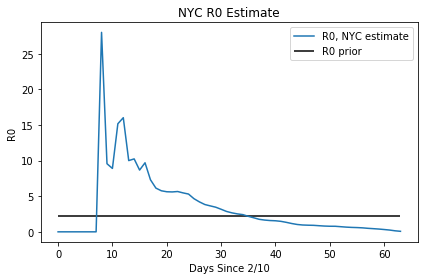

In [331]:
## We assume that deaths occur on average 3 weeks 

plt.plot(np.arange(len(betas)), betas/gamma, label='R0, NYC estimate')
plt.hlines(r0, 0, max(np.arange(len(betas))), label='R0 prior')
plt.legend()
plt.title('NYC R0 Estimate')
plt.xlabel('Days Since 3/3')
plt.ylabel('R0')
plt.tight_layout()
plt.show()